In [67]:
%matplotlib inline 
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from numpy import sqrt, sin, cos, pi, cosh, sinh, tanh, exp, linalg, log
from sympy import symbols, solve
import math
from  scipy.sparse.linalg import eigsh

Let us write a function which creates a matrix consisting of two blocks with prescribed values(later we will write a general with k blocks)

In [68]:
def delta_two_blocks(dimension, size1, value11, value12, value22):
    delta = np.zeros((dimension, dimension))
    delta[:size1, :size1] = value11
    delta[size1:, :size1] = value12
    delta[:size1, size1:] = value12
    delta[size1:, size1:] = value22
    return delta

In [69]:
delta_two_blocks(10, 4, 1, 3, 5)

array([[1., 1., 1., 1., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.]])

### Instance of the problem

Let us generate an instance of the problem with inhomogenous noise (delta instead of snr)

In [70]:
def get_instance(dimension = 1000, *, prior, delta):
    if prior =='gaussian':
        x0 = np.random.normal(0,1, (dimension,1))       
    elif prior == 'radamacher':
        x0 = np.random.choice([-1,1], size=(dimension, 1))
        
    noise = np.triu(np.random.normal(0, 1, (dimension,dimension)))
    noise = noise + noise.T + np.diag(np.random.normal(0,1, dimension))
    
    Y = np.sqrt(1 / dimension) * x0 @ x0.T + noise * delta

    return x0, Y

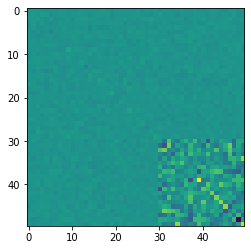

In [71]:
delta = delta_two_blocks(dimension = 50, size1 = 30, value11 = 1, value12 = 1, value22 = 8)
Y = get_instance(dimension = 50, prior = 'gaussian', delta = delta)[1]
plt.imshow(Y, interpolation = 'none')
plt.show()

The plot above clearly illustrates the presence of two communities in the generated instance. In the first community the variance is 1 and the color is quite uniform, whereas in the second the variance is 8 and the color varies wildly across different nodes from the same community.

Let us now implement AMP for the inhomegenous noise 

In [72]:
def damp(new, old, damping=0.85):
    return damping * old + (1-damping) * new

def iterate_amp(tol = 1e-5, max_steps = 100, *, init, prior, Y, delta):
    
    N = Y.shape[0]
    
    xhat_old = np.zeros(N)
    xhat = np.copy(init)
    sigma = np.zeros(N) # Onsager
    
    converged = False
    
    a_old, b_old = 0., np.zeros(N) #parameters of the integral calculating the Bayesian-optimal denoising
    
    for t in range(max_steps):   
        snr = np.array([np.mean(xhat**2) / np.mean((delta[j] * xhat)**2) for j in range(N)])
        Onsager = np.array([np.mean(delta[j]**2 * sigma) for j in range(N)]) 
        
        b_tmp = snr * (np.sqrt(1 / N) * Y.T @ xhat - Onsager * xhat_old)
        a_tmp = snr * np.mean(xhat**2) 
        
        if t == 0: 
            a = a_tmp 
            b = b_tmp
        else:
            a = damp(a_tmp, a_old)
            b = damp(b_tmp, b_old)
            
        xhat_old = xhat
        xhat, sigma = denoiser(b, a, prior=prior)
        
        diff = np.mean((xhat-xhat_old)**2)
        a_old, b_old = np.copy(a), np.copy(b)
        
        if (t>2) and (diff < tol):
            converged = True
            break
            
    if not converged:
        print("AMP didn't converge!")
    
    return xhat

Now we implement the denoiser functions. Note that with inhomegenous noise both parameters b and a are vectors

In [73]:
def denoiser (b, a, *, prior):
    if(prior == 'gaussian'):
        return b/(1+a), 1/(1+a) 
    elif prior == 'radamacher':
        return np.tanh(b), 1-np.tanh(b)**2

We now calculate the average performance of AMP over several runs

In [74]:
def get_mse(x0,xhat):
    return np.min([np.mean((x0-xhat)**2), np.mean((x0+xhat)**2)]) #It is impossible to learn the sign

def averaged_performance(seeds=10, dimension=1000, 
                         initialisation='uninformed', *, prior, delta):
    mse = []
    N = dimension
    for _ in range(seeds):
        init = 1e-3 * np.random.normal(0,1,(N,1)) # default initialisation is uninformed
        # Generate an instance
        x0, Y = get_instance(dimension=dimension, 
                             prior=prior, 
                             delta = delta)
        
        # In informed initialisation start close to signal
        if initialisation == 'informed':
            init += x0 
        elif initialisation == 'spectral':
            _, init = eigh(Y, subset_by_index=[N-1,N-1])
            init *= np.sqrt(len(x0))
        xhat = iterate_amp(init=init, 
                                 prior=prior, 
                                 Y=Y, 
                                 delta = delta)
        mse.append(get_mse(x0,xhat))
        
    return np.mean(mse)

In [75]:
def parameter_curve(initialisation='uninformed', seeds=10, dimension=1000, *, delta_collection, prior):
    
    data = {'param': [], 'mse': []}
    for delta in delta_collection:
        param = delta[0][0]
        print("Computing with parameter = {}".format(param))
        
        mse = averaged_performance(seeds=seeds,dimension=dimension, 
                                            initialisation=initialisation, 
                                            prior=prior, 
                                            delta = delta)
        
        data['param'].append(param)
        data['mse'].append(mse)

    return data

In [76]:
def two_blocks_collection(dimension,*, start, end, points, first_size,diag_scalar):
    N = dimension
    param_range = np.linspace(start, end, points)
    delta_collection = []
    for param in param_range:
        delta_collection.append(delta_two_blocks(N, first_size, param, param, diag_scalar * param))
    return np.array(delta_collection)


In [77]:
def visualize (data):
    fig, ax = plt.subplots(figsize=(7,5))
    plt.plot(data['param'], data['mse'], 
         '.', label='AMP', color='red')
    plt.xlabel('param')
    plt.ylabel('mse')
    plt.legend()
    

Code to solve the variational problem

In [78]:
def Gibbs(qtilde,x0,z, p):
  h = qtilde * x0 + sqrt(qtilde) * z
  return tanh(h)/(1 + exp(qtilde/2)*(1-2*p)/(2*p * cosh(h) ))

def Partition(qtilde,x0,z, p): #the partition function
  h = qtilde * x0 + sqrt(qtilde) * z
  return exp(-qtilde/2)*2*cosh(h)*p+(1-2*p)

def Gauss(z):
  return exp(-z*z/2)/sqrt(2*pi)

def ExpectGibbsRad(qtilde,p):
  BOUNDS = 10
  #x0 = 1  
  av_fp = lambda z: Gauss(z) * p * (Gibbs(qtilde,1,z,p))**2
  av_plus, err = integrate.quad(av_fp, -BOUNDS, BOUNDS)
  #x0 = -1  
  av_fm = lambda z: Gauss(z) * p * (Gibbs(qtilde,-1,z,p))**2
  av_minus, err = integrate.quad(av_fm, -BOUNDS, BOUNDS)
  #x0 = 0
  av_fz = lambda z: Gauss(z) * (1-2*p) * (Gibbs(qtilde,0,z,p))**2
  av_zero, err= integrate.quad(av_fz, -BOUNDS, BOUNDS)
  return av_plus + av_zero + av_minus

def ExpectedLogPartition(qtilde,p):
  BOUNDS = 10
  #x0 = 1  
  av_fp = lambda z: Gauss(z) * p * log(Partition(qtilde,1,z,p))
  av_plus, err = integrate.quad(av_fp, -BOUNDS, BOUNDS)
  #x0 = -1  
  av_fm = lambda z: Gauss(z) * p * log(Partition(qtilde,-1,z,p))
  av_minus, err = integrate.quad(av_fm, -BOUNDS, BOUNDS)
  #x0 = 0
  av_fz = lambda z: Gauss(z) * (1-2*p) * log(Partition(qtilde,0,z,p))
  av_zero, err= integrate.quad(av_fz, -BOUNDS, BOUNDS)
  return av_plus + av_zero + av_minus

def ExpectGibbs(qtilde,prior,p):
  if(prior == 'gaussian'):
        return 1 - 1/(qtilde + 1)
  elif prior == 'radamacher':
        return ExpectGibbsRad(qtilde,p)

def iterate(Qtilde1,Qtilde2,rho1,rho2,Delta_11,Delta_12,Delta_22,damping,prior,p):
  term1 =  ExpectGibbs(Qtilde1,prior,p)
  term2 = ExpectGibbs(Qtilde2,prior,p)
  newQtilde1 = (rho1/Delta_11) * term1 + (rho2/Delta_12)*term2
  newQtilde2 = (rho1/Delta_12) * term1 + (rho2/Delta_22)*term2
  return (1-damping)*newQtilde1+damping*Qtilde1, (1-damping)*newQtilde2+damping*Qtilde2,sqrt((newQtilde1-Qtilde1)**2+(newQtilde2-Qtilde2)**2)

def ComputeQ(Qtilde1,Qtilde2,prior,p):
  return  ExpectGibbs(Qtilde1,prior,p), ExpectGibbs(Qtilde2,prior,p)

def FreeEnergy(Qtilde1,Qtilde2,rho1,rho2,Delta_11,Delta_12,Delta_22,prior,p): #computation of the free energy
  Q1, Q2 = ComputeQ(Qtilde1,Qtilde2,prior,p)
  if(prior == 'gaussian'):
        return -rho1*rho1*Q1*Q1/Delta_11/4 - rho2*rho2*Q2*Q2/Delta_22/4 - 2*rho1*rho2*Q1*Q2/Delta_12/4 + rho1/2 *( Qtilde1 - log(1 + Qtilde1) ) + rho2/2*( Qtilde2 - log(1 + Qtilde2) )
  elif prior == 'radamacher':
        return -rho1*rho1*Q1*Q1/Delta_11/4 - rho2*rho2*Q2*Q2/Delta_22/4 - 2*rho1*rho2*Q1*Q2/Delta_12/4 + rho1*ExpectedLogPartition(Qtilde1,p) + rho2*ExpectedLogPartition(Qtilde2,p)

def Solve_Q(Qtilde1,Qtilde2,rho1,rho2,Delta_11,Delta_12,Delta_22,prior,p):
    conv = 1000
    it = 0
    while (conv>1e-6):
      it = it +1
      damping = 1      
      ok = 0
      t = 0 
      oldconv = conv
      while (ok ==0):
        t = t + 1
        Qtilde1,Qtilde2,conv = iterate(Qtilde1,Qtilde2,rho1,rho2,Delta_11,Delta_12,Delta_22,damping,prior,p)
        if (conv<oldconv):
          ok = 1
        if (t>100):
          ok = 1
        damping = damping / 1.2
    #  print(it,t,damping*1.2,Qtilde1,Qtilde2,conv)      
    return Qtilde1,Qtilde2

In [79]:
def visualize (data_amp, data_optimal):
    fig, ax = plt.subplots(figsize=(7,5))
    plt.plot(data_amp['param'], data_amp['mse'], 
         '.', label='AMP', color='red')
    plt.plot(data_optimal['param'], data_optimal['mse'], 
         '-y', label='Optimal', color='blue')
    plt.xlabel('param')
    plt.ylabel('mse')
    plt.legend()

Generating the MMSE

In [80]:
def optimal_curve(start, end, points, diag_scalar, proportion, prior, p):
    
    rho1 = proportion
    rho2 = 1-rho1
    Delta11 = start
    Delta12 = start
    Delta22 = (start*diag_scalar)**2

    Q1 = 1
    Q2 = 1
    Qtilde1 = rho1/Delta11**2*Q1 + rho2/Delta12**2*Q2
    Qtilde2 = rho1/Delta12**2*Q1 + rho2/Delta22**2*Q2

    MMSEVec = []
    paramvec = []

    param_range = np.linspace(start, end, points)

    for param in param_range:
      Delta_11_new = param**2
      Delta_12_new = param**2
      Delta_22_new = (diag_scalar*param)**2
      Qtilde1,Qtilde2 = Solve_Q(Qtilde1,Qtilde2,rho1,rho2,Delta_11_new,Delta_12_new,Delta_22_new,prior,p)
      MMSEVec.append( 1 - ( rho1**2 * ExpectGibbs(Qtilde1,prior,p)*ExpectGibbs(Qtilde1,prior,p) + 
                           2*rho1*rho2 *  ExpectGibbs(Qtilde1,prior,p) * ExpectGibbs(Qtilde2,prior,p) + 
                           rho2**2 * ExpectGibbs(Qtilde2,prior,p) * ExpectGibbs(Qtilde2,prior,p) )  )
      paramvec.append(param)
    
    return {'param': paramvec, 'mse': MMSEVec}


Computing with parameter = 0.2
Computing with parameter = 0.2578947368421053
Computing with parameter = 0.31578947368421056
Computing with parameter = 0.37368421052631584
Computing with parameter = 0.43157894736842106
Computing with parameter = 0.48947368421052634
Computing with parameter = 0.5473684210526316
Computing with parameter = 0.605263157894737
Computing with parameter = 0.6631578947368422
Computing with parameter = 0.7210526315789474
Computing with parameter = 0.7789473684210526
Computing with parameter = 0.836842105263158
Computing with parameter = 0.8947368421052633
Computing with parameter = 0.9526315789473685
Computing with parameter = 1.0105263157894737
Computing with parameter = 1.0684210526315792
Computing with parameter = 1.1263157894736844
Computing with parameter = 1.1842105263157896
Computing with parameter = 1.2421052631578948
Computing with parameter = 1.3


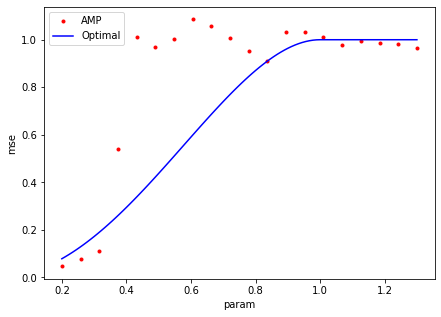

In [81]:
dimension = 100
start = 0.2
end = 1.3
points = 20
delta_collection = two_blocks_collection(dimension = dimension, start = start, end = end, points = points, 
                                         first_size = dimension//2, diag_scalar = 1)
gaussian_prior = parameter_curve(seeds = 6, dimension = dimension,
                                   delta_collection = delta_collection, prior = 'gaussian')
visualize(data_amp = gaussian_prior, data_optimal = 
          optimal_curve(start = start, end = end, points = 100, diag_scalar = 1, proportion = 0.5, prior = 'gaussian', p = 0.5))